In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


# Dataset Reorganizing

Here we would like to first work on a subset of the dataset

In [3]:
# Read the metadata.csv file into a pandas DataFrame
# path = '/content/drive/My Drive/DukeStudies/548L_MLI_Project/Skin_Lesion_Classification/HAM2/'
path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Skin_Lesion_Classification/HAM2/'


In [4]:
df = pd.read_csv(path+'HAM10000_metadata.csv')
df.shape
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [5]:
listdir = os.listdir

# Get the contents of the subset
contents = listdir(path+'HAM10000_images_part_1/')

# Filter the results to only include image files
image_files = [file for file in contents if file.endswith('.jpg')]

# Convert the results to a list
image_file_names = list(image_files)
len(image_file_names)

1661

In [6]:
image_file_names[1] # To check on the image file name construction

'ISIC_0024954.jpg'

The file name of images is encoded as **image_id.jpg**.

In [7]:
# Use list comprehension to remove the extension from each image name
image_ids = [name.split('.')[0] for name in image_file_names]
image_ids[1]
len(image_ids)
subset = df[df['image_id'].isin(image_ids)]
subset.to_csv(path+'new_metadata.csv')
df1 = pd.read_csv(path+'new_metadata.csv')
df1.shape

(1661, 8)

In [8]:
image_paths = []

for image_id in df1['image_id']:
    image_path = os.path.join(path+'HAM10000_images_part_1', image_id + '.jpg')
    image_paths.append(image_path)

In [9]:
# Load the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [10]:
# # Load the metadata.csv file
# labels = df1['dx']

In [11]:
df1['image_path'] = image_paths
df1 = df1.drop('Unnamed: 0', axis=1)
df1.shape

(1661, 8)

In [12]:
df1.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
1,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
2,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
3,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
4,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
5,HAM_0001949,ISIC_0025767,bkl,histo,70.0,male,trunk,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
6,HAM_0001601,ISIC_0025915,bkl,histo,75.0,male,upper extremity,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
7,HAM_0003301,ISIC_0025033,bkl,histo,60.0,male,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
8,HAM_0004884,ISIC_0025937,bkl,histo,75.0,male,upper extremity,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
9,HAM_0006574,ISIC_0025567,bkl,histo,40.0,male,back,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...


In [13]:
image_ids = df1['image_id']
image_paths = df1['image_path']

(600, 450)


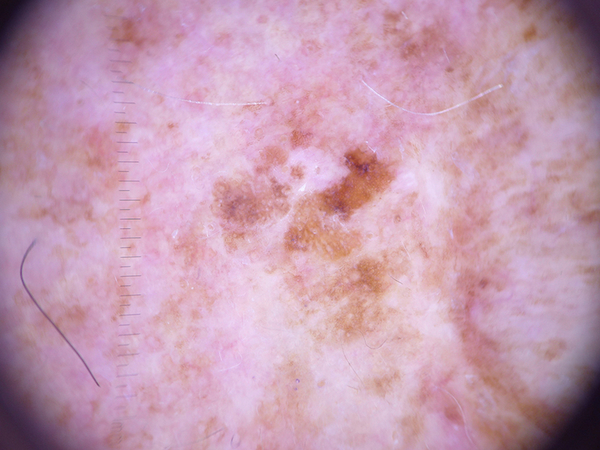

In [14]:
# loading a sample image
sample_image = Image.open(image_paths[0])
print(sample_image.size)
sample_image


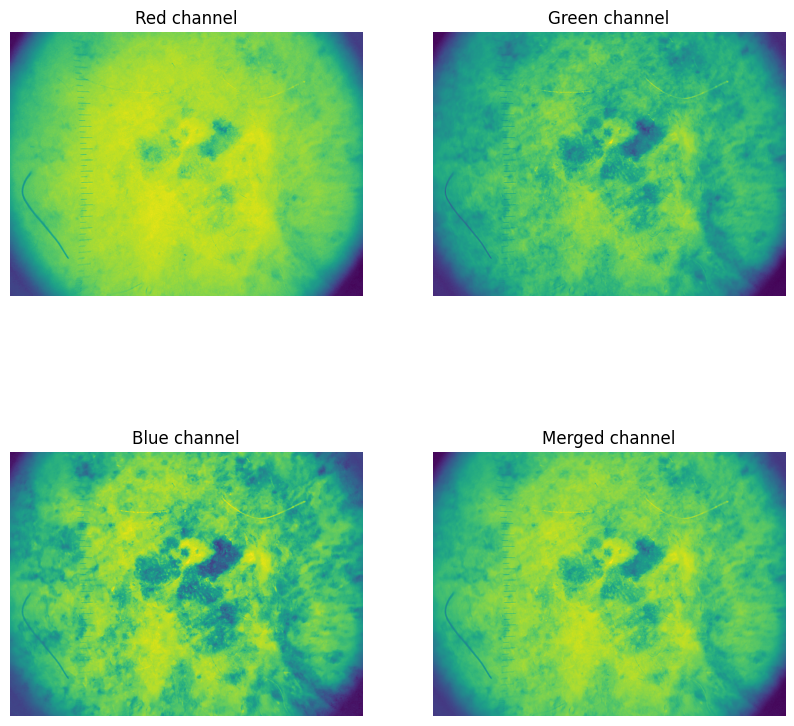

(450, 600)
(450, 600)


In [36]:
import cv2
from google.colab.patches import cv2_imshow

# Load image
image = cv2.imread(image_paths[0])

# Split image into RGB channels
b, g, r = cv2.split(image)

# a1 = 1 #@param {type:"slider", min:0, max:4, step: 0.05}
# a2 = 1 #@param {type:"slider", min:0, max:4, step: 0.05}
# a3 = 4 - a1 - a2

# a = a1*r + a2*g + a3*b

# Merge RGB channels with different weights
merged = cv2.addWeighted(cv2.addWeighted(r, 0.5, g, 0.3, 0), 0.6, b, 0.2, 0)

# # Merge RGB channels to recreate the original image
# merged = cv2.merge([r, g, b])

# Display each channel separately using matplotlib
plt.figure(figsize=(10,10))

plt.subplot(221)
plt.imshow(r)
plt.title('Red channel')
plt.axis('off')

plt.subplot(222)
plt.imshow(g)
plt.title('Green channel')
plt.axis('off')

plt.subplot(223)
plt.imshow(b)
plt.title('Blue channel')
plt.axis('off')

plt.subplot(224)
plt.imshow(merged)
plt.title('Merged channel')
plt.axis('off')

plt.show()

print(merged.shape)
print(r.shape)